Importing Librarys

In [ ]:
import pandas as pd
import numpy as np
import os
import cv2
import seaborn as sns
from pathlib import Path
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications import VGG16, MobileNetV2, EfficientNetB0
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import InputLayer, Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, MaxPool2D
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import Rescaling, RandomFlip, RandomRotation, RandomZoom, RandomContrast, RandomTranslation

In [ ]:
image_size = 256
train_data_dir = "/content/drive/MyDrive/melanoma_cancer_dataset/test"
test_data_dir = "/content/drive/MyDrive/GBCU-With_train_test/imgs/test"
CLASSNAMES = os.listdir('/content/drive/MyDrive/melanoma_cancer_dataset/train')
def plot_scores(histo):
    accuracies = histo.history['accuracy']
    val_accuracies = histo.history['val_accuracy']
    epochs = range(len(accuracies))
    plt.plot(epochs,accuracies,'b',label='Accuracy on train')
    plt.plot(epochs,val_accuracies,'r',label='Accuracy on test')
    plt.title('Score')
    plt.legend()
    plt.show()
    print('FINAL VALID_ACC:',val_accuracies[-1])
    print('FINAL TRAIN_ACC:',accuracies[-1])

# Getting model embeddings
def get_model(model_url: str, image_size: int , num_classes: int = 0) -> tf.keras.Model:
    inputs = tf.keras.Input((image_size, image_size, 3))
    hub_module = hub.KerasLayer(model_url, trainable=True)
    x = hub_module(inputs, training=False)
    if num_classes > 0:
        x = Dropout(rate=0.5)(x)
        outputs = Dense(num_classes, activation="softmax")(x)
    else:
        outputs = x
    return tf.keras.Model(inputs, outputs)
def get_dataAugmentation(image_size):
    dataAugmentation = Sequential([RandomFlip("horizontal_and_vertical",input_shape=(image_size, image_size, 3)),RandomRotation(0.3),RandomZoom(0.1)])
    return dataAugmentation
def img_reader(dir_root,image_size):
    images = []
    lables = []
    for p in Path(dir_root).rglob('*.jpg'):
        img = cv2.imread(str(p))
        images.append(cv2.resize(img,(image_size, image_size)))
        lables.append(CLASSNAMES.index(p.parent.name))
    return np.array(images), to_categorical(np.array(lables))

(4174, 256, 256, 3) (4174, 2)
(464, 256, 256, 3) (464, 2)


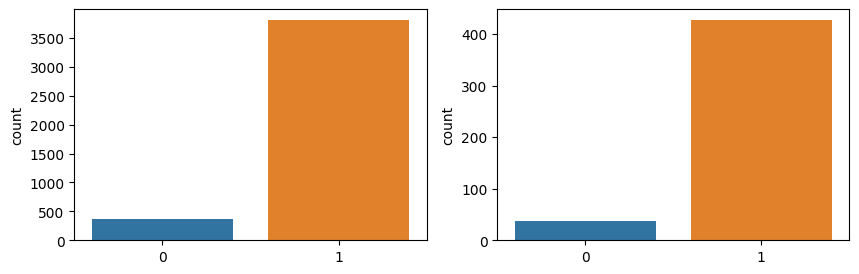

In [ ]:
X_train, y_train = img_reader('/content/drive/MyDrive/melanoma_cancer_dataset',image_size)
X_train, y_train = shuffle(X_train, y_train, random_state=101)
X_train,X_test,y_train,y_test = train_test_split(X_train, y_train, test_size=0.1,random_state=101)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)
plt.figure(figsize = (10,3))
for i,j in enumerate([y_train,y_test]):
    plt.subplot(1,2,i+1)
#     sns.countplot(x = [CLASSNAMES[np.argmax(id) for id in j])
    sns.countplot(x = [np.argmax(id) for id in j])

In [ ]:
'''
Train  random forest classifier on images
'''
rf = RandomForestClassifier(n_estimators=10, random_state=42)
rf.fit(X_train.reshape(X_train.shape[0],-1), y_train)
# Evaluate the classifier on the test set
accuracy_train = rf.score(X_train.reshape(X_train.shape[0],-1), y_train)
accuracy_test = rf.score(X_test.reshape(X_test.shape[0],-1), y_test)
print('Random Forest train Accuracy:', accuracy_train)
print('Random Forest test Accuracy:', accuracy_test)

Random Forest train Accuracy: 0.9935313847628174
Random Forest test Accuracy: 0.9331896551724138


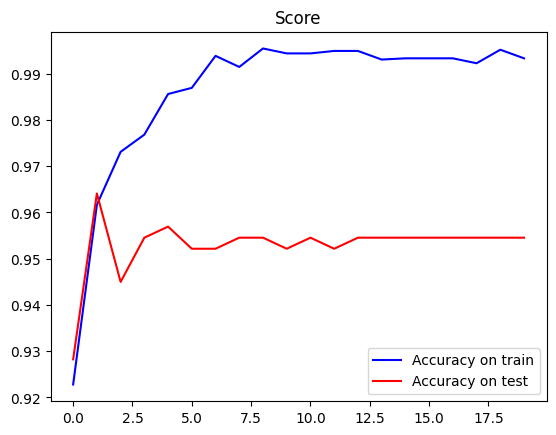

FINAL VALID_ACC: 0.9545454382896423
FINAL TRAIN_ACC: 0.9933440089225769
15/15 [==============================] - 5s 351ms/step
FINAL TEST_ACC: 0.9310344827586207


In [ ]:
'''
transfer learning of pretrained VGG16
'''
backbone = VGG16(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))
backbone.trainable =False
model = Sequential()
model.add(backbone)
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(2,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,mode='auto',verbose=0)
history = model.fit(X_train, y_train, validation_split=0.1, epochs=20,verbose=0, batch_size = 32, shuffle = True, callbacks = reduce_lr)
plot_scores(history)
print('FINAL TEST_ACC:',accuracy_score(np.argmax(model.predict(X_test),axis=1),np.argmax(y_test,axis=1)))

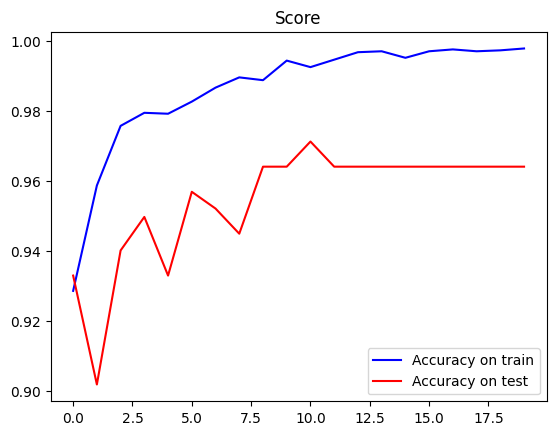

FINAL VALID_ACC: 0.9641148447990417
FINAL TRAIN_ACC: 0.9978700876235962
15/15 [==============================] - 2s 146ms/step
FINAL TEST_ACC: 0.9461206896551724


In [ ]:
'''
finetune on ending layers of pretrained VGG16
'''
backbone = VGG16(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))
backbone.trainable =False
for layer in backbone.layers[15:]:
    layer.trainable = True
model = Sequential()
model.add(backbone)
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(2,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,mode='auto',verbose=0)
history = model.fit(X_train, y_train, validation_split=0.1, epochs=20,verbose=0, batch_size = 32, shuffle = True, callbacks = reduce_lr)
plot_scores(history)
print('FINAL TEST_ACC:',accuracy_score(np.argmax(model.predict(X_test),axis=1),np.argmax(y_test,axis=1)))

In [ ]:
im

In [ ]:
converter=tf.lite.TFLiteConverter.from_keras_model(model)

NameError: ignored

In [ ]:
tflite=converter.convert()